<a href="https://colab.research.google.com/github/hsnam95/my/blob/main/gensim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic models with Gensim

Gensim is a popular library for topic modeling. Here we'll see how it stacks up to scikit-learn.

### Downloading necessary files
* **recipes.csv:** recipes - a list of recipes (but only with ingredient names)
* **state-of-the-union.csv:** State of the Union addresses - each presidential address from 1970 to 2012


In [1]:
# Make data directory if it doesn't exist
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/text-analysis/data/recipes.csv -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/text-analysis/data/state-of-the-union.csv -P data

--2023-04-28 01:00:08--  https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/text-analysis/data/recipes.csv
Resolving nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)|162.243.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6483086 (6.2M) [text/csv]
Saving to: ‘data/recipes.csv’

recipes.csv         100%[===================>]   6.18M  9.94MB/s    in 0.6s    

2023-04-28 01:00:09 (9.94 MB/s) - ‘data/recipes.csv’ saved [6483086/6483086]

--2023-04-28 01:00:09--  https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/text-analysis/data/state-of-the-union.csv
Resolving nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)|162.243.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10501219 (10M) [text/csv]
Saving to: ‘data/state-of-the-union

### Data cleaning

In [2]:
import pandas as pd
df = pd.read_csv("data/state-of-the-union.csv")
# Clean it up a little bit, removing non-word characters (numbers and ___ etc)
df.content = df.content.str.replace("[^A-Za-z ]", " ")
df.head()

<ipython-input-2-9622a8ac5841>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df.content = df.content.str.replace("[^A-Za-z ]", " ")


,year,content
0,1790,George Washington January Fellow Citi...
1,1790,State of the Union Address George Washington ...
2,1791,State of the Union Address George Washington ...
3,1792,State of the Union Address George Washington ...
4,1793,State of the Union Address George Washington ...


### Explore data with Wordcloud

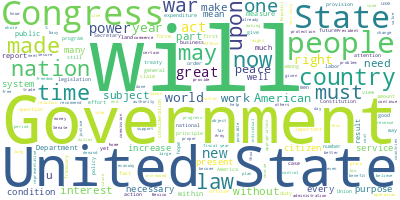

In [3]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df.content.values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

### Prepare data for LDA

gensim.utils.simple_preprocess convert a document into a list of tokens. This lowercases, tokenizes, de-accents (optional)

In [4]:
from gensim.utils import simple_preprocess
df.content = df.content.apply(simple_preprocess)

remove stopwords

In [5]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# stop_words.extend(['from', 'to']) # add more if want
df.content = df.content.apply(lambda words: [word for word in words if word not in stop_words])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Using LDA with Gensim

In [13]:
texts = df.content
from gensim import corpora
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=5, no_above=0.5)

corpus = [dictionary.doc2bow(text) for text in texts]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
from gensim import models
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
n_topics = 15

# Build an LSI model
lsi_model = models.LsiModel(corpus_tfidf,
                            id2word=dictionary,
                            num_topics=n_topics)

n_words = 10
topic_words = pd.DataFrame({})

for i, topic in enumerate(lsi_model.get_topics()):
    top_feature_ids = topic.argsort()[-n_words:][::-1]
    feature_values = topic[top_feature_ids]
    words = [dictionary[id] for id in top_feature_ids]
    topic_df = pd.DataFrame({'value': feature_values, 'word': words, 'topic': i})
    topic_words = pd.concat([topic_words, topic_df], ignore_index=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gensim/models/lsimodel.py:963: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(


In [21]:
from gensim import corpora
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=2000)
corpus = [dictionary.doc2bow(text) for text in texts]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
from gensim import models
n_topics = 15
lda_model = models.LdaModel(corpus=corpus, num_topics=n_topics)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
lda_model.print_topics()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.004*"1563" + 0.004*"1986" + 0.003*"1265" + 0.003*"1930" + 0.003*"150" + 0.003*"1247" + 0.003*"1974" + 0.003*"975" + 0.002*"1989" + 0.002*"1995"'),
 (1,
  '0.004*"1563" + 0.003*"975" + 0.003*"62" + 0.002*"950" + 0.002*"1451" + 0.002*"1332" + 0.002*"150" + 0.002*"19" + 0.002*"972" + 0.002*"576"'),
 (2,
  '0.003*"1563" + 0.003*"1930" + 0.003*"1986" + 0.002*"1628" + 0.002*"1265" + 0.002*"62" + 0.002*"1971" + 0.002*"1247" + 0.002*"1332" + 0.002*"150"'),
 (3,
  '0.004*"1986" + 0.003*"1563" + 0.003*"1265" + 0.003*"1930" + 0.003*"1971" + 0.002*"438" + 0.002*"1964" + 0.002*"1974" + 0.002*"150" + 0.002*"1999"'),
 (4,
  '0.003*"265" + 0.003*"1986" + 0.002*"950" + 0.002*"1247" + 0.002*"1563" + 0.002*"1628" + 0.002*"1971" + 0.002*"150" + 0.002*"438" + 0.002*"1451"'),
 (5,
  '0.004*"1563" + 0.004*"1265" + 0.003*"1986" + 0.002*"1930" + 0.002*"1549" + 0.002*"1247" + 0.002*"1971" + 0.002*"1995" + 0.002*"438" + 0.002*"150"'),
 (6,
  '0.005*"1563" + 0.003*"1866" + 0.003*"265" + 0.003*"1628" + 0

In [24]:
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


ERROR:concurrent.futures:exception calling callback for <Future at 0x7f5923ec25c0 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py", line 391, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
ModuleNotFoundError: No module named 'pandas.core.indexes.numeric'
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/_base.py", line 26, in _invoke_callbacks
    callback(self)
  File "/usr/local/lib/python3.10/dist-packages/joblib/parallel.py", line 385, in __call__
    self.parallel.dispatch_next()
  File "/usr/local/lib/python3.10/dist-packages/joblib/p

BrokenProcessPool: ignored